In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding notebook

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from enum import Enum

import pickle
import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool

import torch
import torch.nn.functional as F
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import glob
import pickle
from tqdm import tqdm
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map
from graph_creator.MapGraph import MapGraph
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg

### Data prep

In [3]:
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/*.pkl")
graph_paths = [path for path in graph_paths if "2025-09-05" in path]
print(len(graph_paths))


4961


In [4]:
# Load data
graph_ds = GraphDataset(graph_paths)
train_loader = DataLoader(graph_ds, batch_size=32, shuffle=True)

/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# set([path.split("/")[-1].split("_")[1] for path in graph_paths])

In [6]:
# try out data loader
graph_ds.__getitem__(10)
batch = next(iter(train_loader))

### Training

In [7]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)

# Training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
# get the pre-training loss
total_loss = 0

with torch.no_grad():
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)
        outputs1 = model(batch)
        outputs2 = model(aug_batch)
        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        total_loss += loss.item()

# if epoch % 1 == 0:
print(f'pre-training loss:: {total_loss/len(train_loader):.4f}')

pre-training loss:: 2.6860


In [9]:
for epoch in range(25):
    total_loss = 0
   
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)

        optimizer.zero_grad()

        outputs1 = model(batch)
        outputs2 = model(aug_batch)

        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # if epoch % 1 == 0:
    print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')



Epoch 0, Loss: 0.7876
Epoch 1, Loss: 0.4489
Epoch 2, Loss: 0.3346
Epoch 3, Loss: 0.3090
Epoch 4, Loss: 0.2826
Epoch 5, Loss: 0.2491
Epoch 6, Loss: 0.2243
Epoch 7, Loss: 0.2193
Epoch 8, Loss: 0.2253
Epoch 9, Loss: 0.1930
Epoch 10, Loss: 0.2004
Epoch 11, Loss: 0.2087
Epoch 12, Loss: 0.1794
Epoch 13, Loss: 0.1837
Epoch 14, Loss: 0.1833
Epoch 15, Loss: 0.1755
Epoch 16, Loss: 0.1583
Epoch 17, Loss: 0.1687
Epoch 18, Loss: 0.1563
Epoch 19, Loss: 0.1516
Epoch 20, Loss: 0.1571
Epoch 21, Loss: 0.1602
Epoch 22, Loss: 0.1572
Epoch 23, Loss: 0.1550
Epoch 24, Loss: 0.1477


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
for epoch in range(25):
    total_loss = 0
   
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)

        optimizer.zero_grad()

        outputs1 = model(batch)
        outputs2 = model(aug_batch)

        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # if epoch % 1 == 0:
    print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')

# Save model
# torch.save(model.state_dict(), 'gine_model.pth')

Epoch 0, Loss: 0.1249
Epoch 1, Loss: 0.1247
Epoch 2, Loss: 0.1318
Epoch 3, Loss: 0.1246
Epoch 4, Loss: 0.1173
Epoch 5, Loss: 0.1223
Epoch 6, Loss: 0.1213
Epoch 7, Loss: 0.1150
Epoch 8, Loss: 0.1093
Epoch 9, Loss: 0.1115
Epoch 10, Loss: 0.1102
Epoch 11, Loss: 0.1129
Epoch 12, Loss: 0.1151
Epoch 13, Loss: 0.1097
Epoch 14, Loss: 0.1061
Epoch 15, Loss: 0.1100
Epoch 16, Loss: 0.1036
Epoch 17, Loss: 0.0958
Epoch 18, Loss: 0.1058
Epoch 19, Loss: 0.1016
Epoch 20, Loss: 0.1029
Epoch 21, Loss: 0.1123
Epoch 22, Loss: 0.0951
Epoch 23, Loss: 0.0959
Epoch 24, Loss: 0.1041


### Inference

In [11]:
# Inference loop
model.eval()
all_embeddings = []
all_paths = []

with torch.no_grad():
   for batch in tqdm(train_loader):  # or test_loader
       all_paths.extend(batch[1]) 
       batch = batch[0].to(device)
       outputs = model(batch)
       embeddings = outputs['embeddings']
       all_embeddings.append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = torch.cat(all_embeddings, dim=0)
print(f'Extracted {final_embeddings.shape[0]} embeddings of dimension {final_embeddings.shape[1]}')

100%|██████████| 156/156 [00:01<00:00, 88.53it/s]

Extracted 4961 embeddings of dimension 256


In [12]:
graph_dates = [path.split("/")[-1].split("_")[1] for path in all_paths]
#all_paths


### Visualization of embeddings

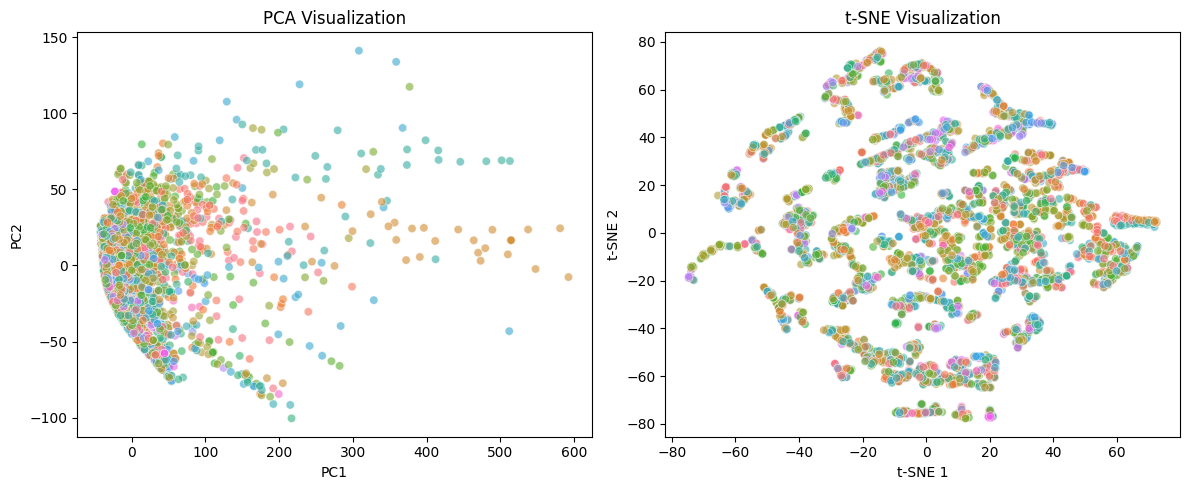

In [13]:

# Convert embeddings to numpy
embeddings_np = final_embeddings.numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["timestamp"] = graph_dates
pca_df["graph_path"] = all_paths
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="timestamp", legend = False, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["timestamp"] = graph_dates
tsne_df["graph_path"] = all_paths

plt.subplot(1, 2, 2)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="timestamp", legend = False, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [14]:
os.getcwd()
os.chdir("../..")
os.getcwd()

'/home/tmuehlen/repos/graph_coverage'

2025-09-05 21:12:48.305061_7_9 2025-09-05 21:12:48.305061
2025-09-05 21:25:02.436837_0_1 2025-09-05 21:25:02.436837


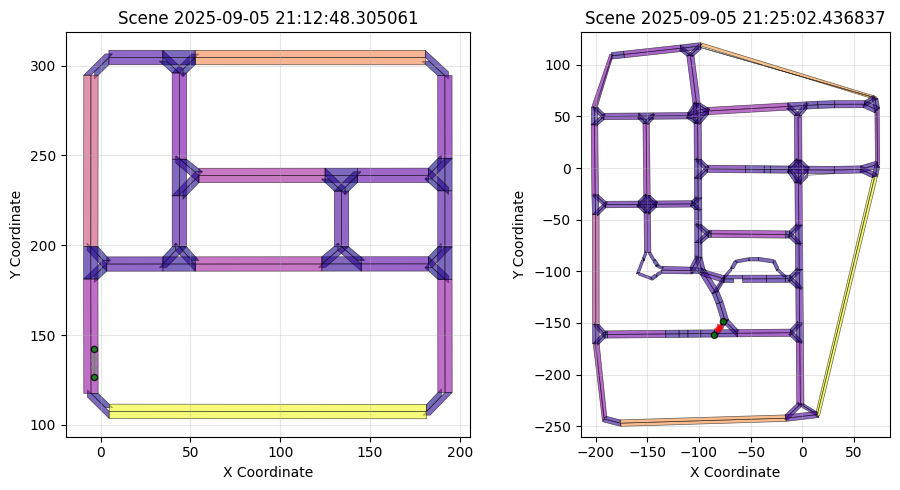

2025-09-05 21:28:19.108402_14_8 2025-09-05 21:28:19.108402
2025-09-05 21:28:19.108402_5_9 2025-09-05 21:28:19.108402


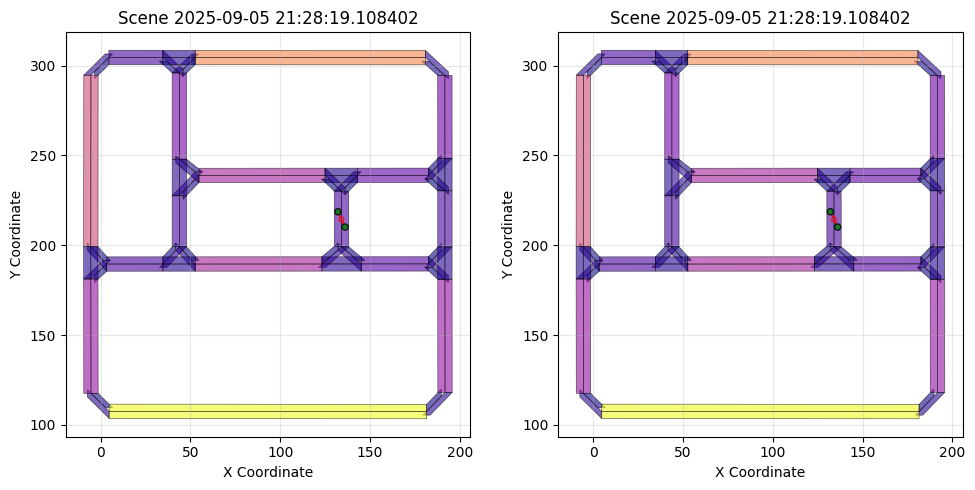

2025-09-05 21:36:07.600472_10_2 2025-09-05 21:36:07.600472
2025-09-05 21:26:23.680409_15_6 2025-09-05 21:26:23.680409


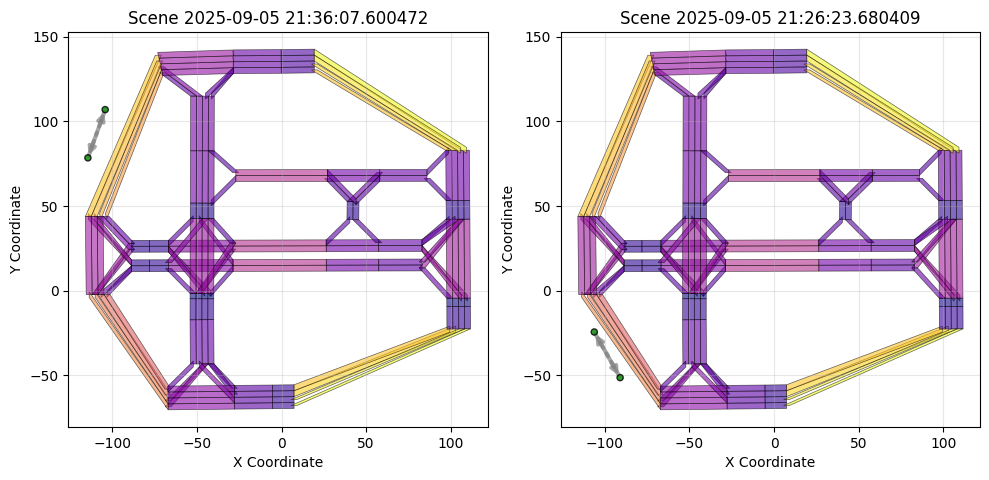

2025-09-05 22:12:37.118738_11_0 2025-09-05 22:12:37.118738
2025-09-05 21:31:44.241791_13_2 2025-09-05 21:31:44.241791


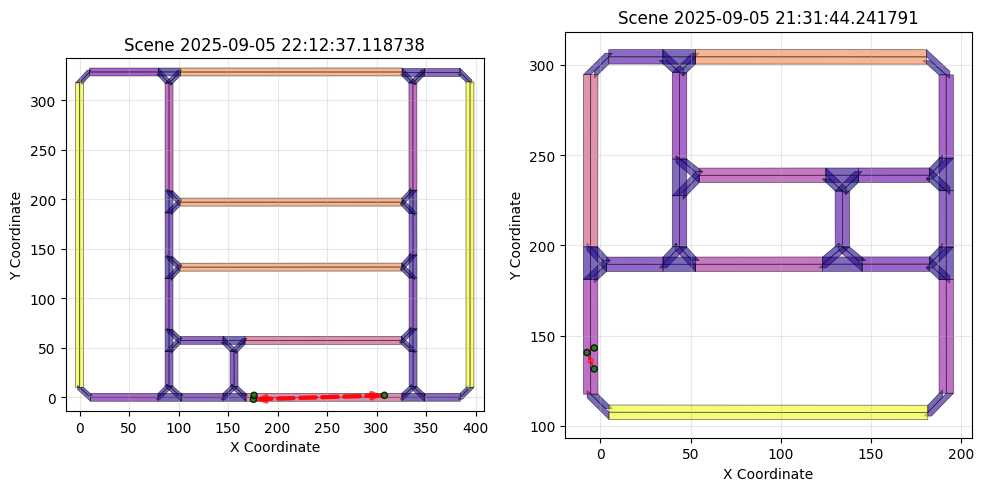

2025-09-05 21:20:17.371842_8_4 2025-09-05 21:20:17.371842
2025-09-05 21:20:17.371842_9_4 2025-09-05 21:20:17.371842


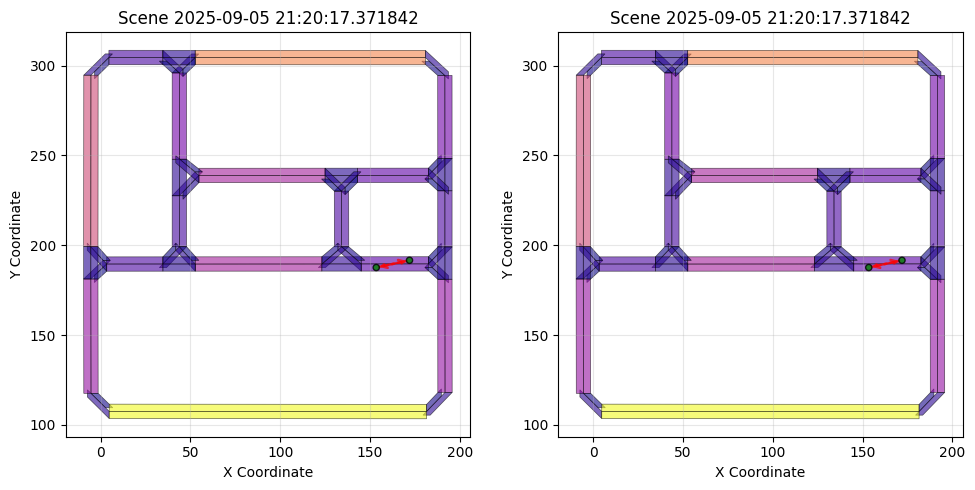

2025-09-05 21:13:37.320700_13_3 2025-09-05 21:13:37.320700
2025-09-05 21:41:34.315588_5_0 2025-09-05 21:41:34.315588


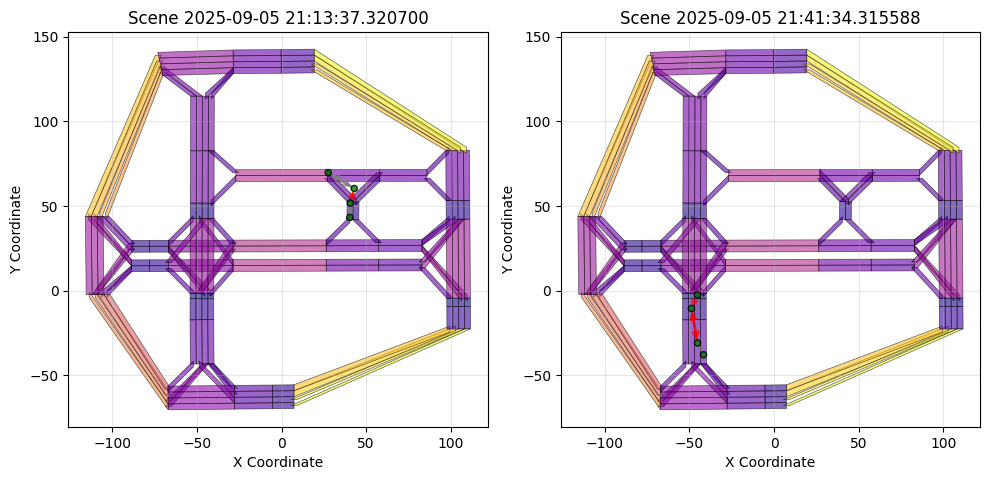

2025-09-05 21:23:45.684656_3_1 2025-09-05 21:23:45.684656
2025-09-05 22:13:58.148789_2_1 2025-09-05 22:13:58.148789


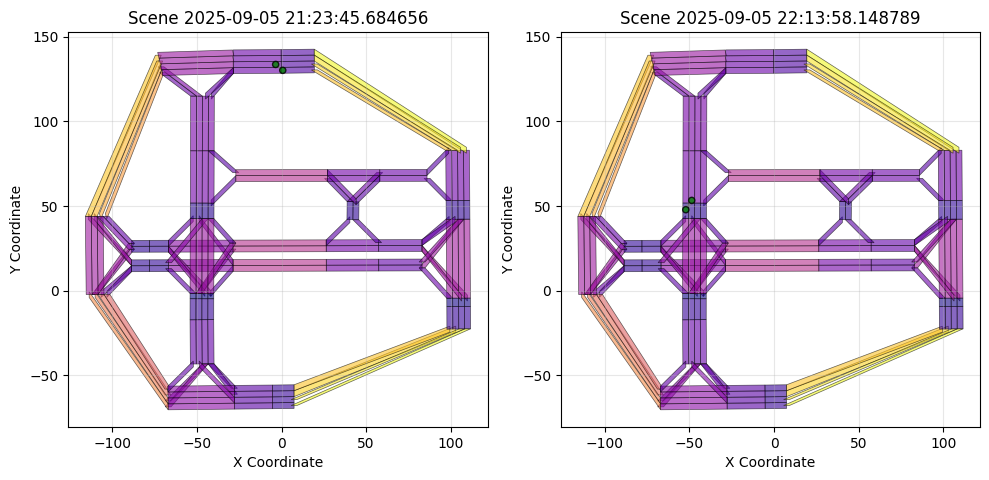

2025-09-05 23:11:53.030761_6_0 2025-09-05 23:11:53.030761
2025-09-05 23:11:53.030761_12_0 2025-09-05 23:11:53.030761


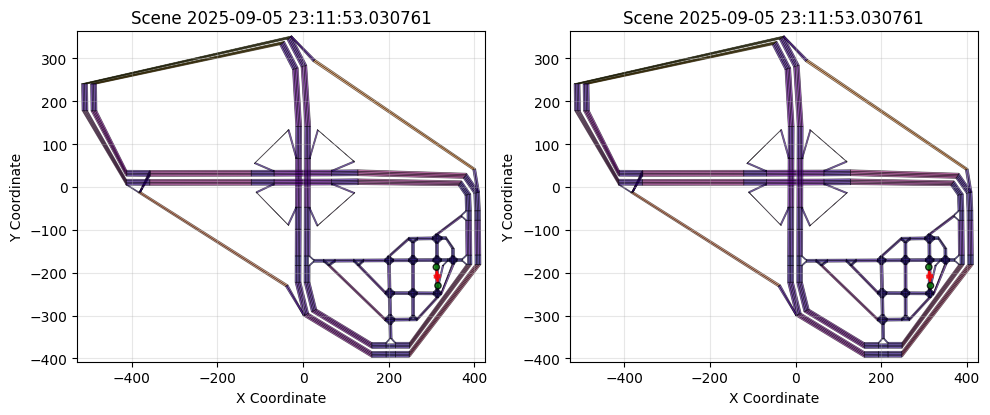

2025-09-05 21:24:17.725796_3_3 2025-09-05 21:24:17.725796
2025-09-05 21:24:17.725796_4_3 2025-09-05 21:24:17.725796


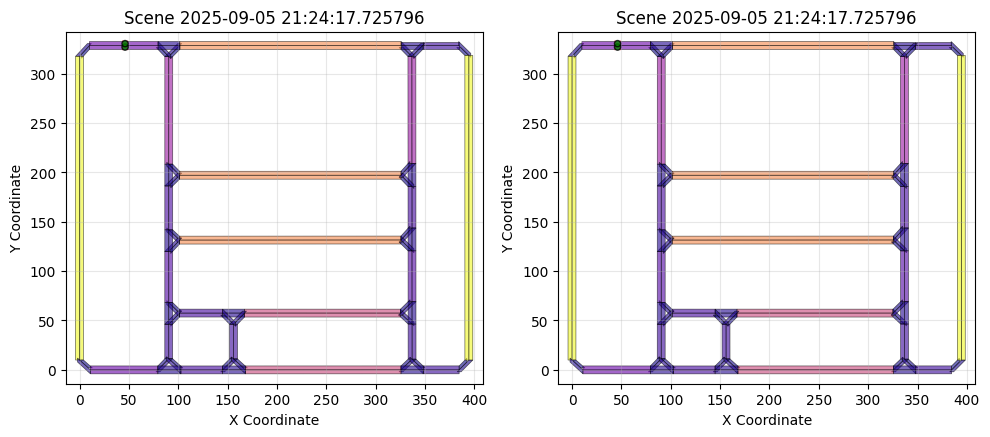

2025-09-05 22:58:51.955777_11_1 2025-09-05 22:58:51.955777
2025-09-05 21:13:37.320700_9_0 2025-09-05 21:13:37.320700


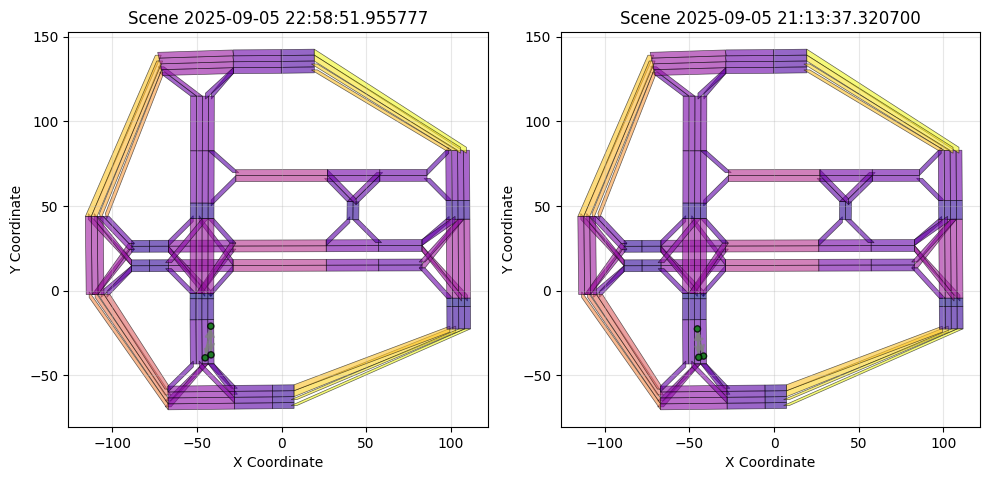

In [16]:
for i in range(10):
    first = pca_df.sample(1)
    pca_df["dist"] = (pca_df.pca1 - first.pca1.iloc[0])**2 + (pca_df.pca2 - first.pca2.iloc[0])**2 
    pca_df.sort_values("dist", inplace=True)
    #print(pca_df.graph_path.iloc[0])
    #print(pca_df.graph_path.iloc[1])
    graph_1 = pca_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
    graph_2 = pca_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
    scn_1 = graph_1[:26]
    scn_2 = graph_2[:26]
    print(graph_1, scn_1)
    print(graph_2, scn_2)
    pca_df.head(2)
    file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_1}.pkl"
    with open(file_path_1, 'rb') as f:
        nx_graph_1 = pickle.load(f)
    file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
    with open(file_path_2, 'rb') as f:
        nx_graph_2 = pickle.load(f)
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # First scene (left subplot)
    g_map = MapGraph()
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
    fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
    fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
    fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
    ax1.set_title(f'Scene {scn_1}')
    # Second scene (right subplot)
    g_map = MapGraph()
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
    fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
    fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
    fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
    ax2.set_title(f'Scene {scn_2}')
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


# Notebook junkyard

In [ ]:

# Define mappings for one-hot encodings
ACTOR_TYPE_MAPPING = {
    'VEHICLE': 0,
    'PEDESTRIAN': 1,
    'CYCLIST': 2,
    'MOTORCYCLE': 3,
    # Add more types as needed
}

EDGE_TYPE_MAPPING = {
    'neighbor_vehicle': 0,
    'opposite_vehicle': 1,
    'same_lane': 2,
    'adjacent_lane': 3,
    'following': 4,
    'intersection': 5,
    # Add more edge types as needed
}

In [ ]:
from torch.utils.data import Dataset

# Helper function to get feature dimensions
def get_feature_dimensions(actor_type_mapping=None, edge_type_mapping=None):
    """Get the dimensions of node and edge features"""
    if actor_type_mapping is None:
        actor_type_mapping = ACTOR_TYPE_MAPPING
    if edge_type_mapping is None:
        edge_type_mapping = EDGE_TYPE_MAPPING
    
    # Node features: 1 (lon_speed) + num_actor_types (one-hot)
    node_features = 1 + len(actor_type_mapping)
    
    # Edge features: 1 (path_length) + num_edge_types (one-hot)
    edge_features = 1 + len(edge_type_mapping)
    
    return node_features, edge_features

def networkx_to_pyg(nx_graph, actor_type_mapping=None, edge_type_mapping=None):
    """
    Convert NetworkX graph to PyTorch Geometric Data object.
    
    Args:
        nx_graph: NetworkX graph with node and edge attributes
        actor_type_mapping: Dict mapping actor types to indices
        edge_type_mapping: Dict mapping edge types to indices
    
    Returns:
        PyTorch Geometric Data object
    """
    
    # Use default mappings if none provided
    if actor_type_mapping is None:
        actor_type_mapping = ACTOR_TYPE_MAPPING
    if edge_type_mapping is None:
        edge_type_mapping = EDGE_TYPE_MAPPING
    
    # Get node mapping (NetworkX nodes might not be sequential integers)
    nodes = list(nx_graph.nodes())
    node_mapping = {node: idx for idx, node in enumerate(nodes)}
    num_nodes = len(nodes)
    
    # Extract node features
    node_features = []
    for node in nodes:
        node_data = nx_graph.nodes[node]
        
        # Extract lon_speed (continuous feature)
        lon_speed = node_data.get('lon_speed', 0.0)
        
        # Extract actor_type and convert to one-hot
        actor_type = node_data.get('actor_type')
        if hasattr(actor_type, 'value'):  # Handle enum
            actor_type_str = actor_type.value
        else:
            actor_type_str = str(actor_type)
        
        # Get actor type index
        actor_type_idx = actor_type_mapping.get(actor_type_str, 0)  # Default to 0 if unknown
        
        # Create one-hot encoding for actor type
        num_actor_types = len(actor_type_mapping)
        actor_onehot = [0.0] * num_actor_types
        actor_onehot[actor_type_idx] = 1.0
        
        # Combine features: [lon_speed, actor_type_onehot...]
        node_feature = [lon_speed] + actor_onehot
        node_features.append(node_feature)
    
    # Convert to tensor
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Extract edges and edge features
    edge_index = []
    edge_features = []
    
    for source, target, edge_data in nx_graph.edges(data=True):
        # Map node IDs to indices
        source_idx = node_mapping[source]
        target_idx = node_mapping[target]
        
        edge_index.append([source_idx, target_idx])
        
        # Extract path_length (continuous feature)
        path_length = edge_data.get('path_length', 0.0)
        
        # Extract edge_type and convert to one-hot
        edge_type = edge_data.get('edge_type', 'unknown')
        edge_type_idx = edge_type_mapping.get(edge_type, 0)  # Default to 0 if unknown
        
        # Create one-hot encoding for edge type
        num_edge_types = len(edge_type_mapping)
        edge_onehot = [0.0] * num_edge_types
        edge_onehot[edge_type_idx] = 1.0
        
        # Combine features: [path_length, edge_type_onehot...]
        edge_feature = [path_length] + edge_onehot
        edge_features.append(edge_feature)
    
    # Convert to tensors
    if len(edge_index) > 0:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)
    else:
        # Handle graphs with no edges
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 1 + len(edge_type_mapping)), dtype=torch.float)
    
    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data



class GraphDataset(Dataset):
    def __init__(self, graph_paths):
        self.graph_paths = graph_paths
        
    def __len__(self):
        return len(self.graph_paths)
    
    def __getitem__(self, idx):
        file_path = self.graph_paths[idx]
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        pyg_data = networkx_to_pyg(nx_graph)
        return pyg_data, file_path


In [ ]:
# Enhanced model with training capabilities
class TrainableGraphGINE(torch.nn.Module):
    def __init__(self, node_features, edge_features, embedding_dim=128, hidden_dim=64, num_layers=3, num_classes=None):
        """
        GINE model for graph-level embeddings with optional classification
        
        Args:
            node_features: Number of node features
            edge_features: Number of edge features  
            embedding_dim: Final embedding dimension
            hidden_dim: Hidden layer dimension
            num_layers: Number of GINE layers
            num_classes: Number of classes for supervised learning (None for unsupervised)
        """
        super().__init__()
        
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # GINE layers
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # First layer
        self.convs.append(
            GINEConv(
                torch.nn.Sequential(
                    torch.nn.Linear(node_features, hidden_dim),
                    torch.nn.BatchNorm1d(hidden_dim),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim, hidden_dim)
                ),
                edge_dim=edge_features
            )
        )
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(
                GINEConv(
                    torch.nn.Sequential(
                        torch.nn.Linear(hidden_dim, hidden_dim),
                        torch.nn.BatchNorm1d(hidden_dim),
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim)
                    ),
                    edge_dim=edge_features
                )
            )
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_dim))
        
        # Graph-level pooling and embedding projection
        self.embedding_proj = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 3, embedding_dim),  # *3 for mean+max+sum pooling
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(embedding_dim, embedding_dim)
        )
        
        # Projection head for contrastive learning (unsupervised)
        self.projection_head = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, embedding_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(embedding_dim, embedding_dim // 2)
        )
        
        # Classification head (supervised)
        if num_classes is not None:
            self.classifier = torch.nn.Sequential(
                torch.nn.Dropout(0.3),
                torch.nn.Linear(embedding_dim, num_classes)
            )
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Handle empty edge attributes
        if edge_attr.size(0) == 0:
            edge_attr = None
        
        # GINE layers
        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x = conv(x, edge_index, edge_attr)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.2, training=self.training)
        
        # Graph-level pooling
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)
        sum_pool = global_add_pool(x, batch)
        
        # Concatenate pooling strategies
        graph_repr = torch.cat([mean_pool, max_pool, sum_pool], dim=1)
        
        # Final embedding
        embeddings = self.embedding_proj(graph_repr)
        
        outputs = {'embeddings': embeddings}
        
        # Add projection for contrastive learning
        outputs['projection'] = self.projection_head(embeddings)
        
        # Add classification if applicable
        if hasattr(self, 'classifier'):
            outputs['logits'] = self.classifier(embeddings)
        
        return outputs
    
    def get_embedding(self, data):
        """Extract embeddings only"""
        self.eval()
        with torch.no_grad():
            outputs = self.forward(data)
            return outputs['embeddings']


In [ ]:
# Contrastive loss
def contrastive_loss(z1, z2, temperature=0.1):
    """InfoNCE contrastive loss"""
    batch_size = z1.size(0)
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    
    # Compute similarity matrix
    sim_matrix = torch.mm(z1, z2.t()) / temperature
    
    # Labels for positive pairs (diagonal)
    labels = torch.arange(batch_size, device=z1.device)
    
    return F.cross_entropy(sim_matrix, labels)

# Data augmentation for contrastive learning
def augment_graph(data):
    """Simple graph augmentation"""
    augmented_data = data.clone()
    
    # Add noise to continuous features
    # Node features: first feature is lon_speed
    if augmented_data.x.size(1) > 0:
        augmented_data.x[:, 0] += torch.randn_like(augmented_data.x[:, 0]) * 0.1
    
    # Edge features: first feature is path_length
    if augmented_data.edge_attr.size(0) > 0 and augmented_data.edge_attr.size(1) > 0:
        augmented_data.edge_attr[:, 0] += torch.randn_like(augmented_data.edge_attr[:, 0]) * 0.1
    
    return augmented_data

